## Abstract

Solving large systems of linear equations is a central task in scientific computing, underpinning applications in machine learning, physics simulation, optimization, and computational biology. This notebook examines two quantum approaches to linear system solving: the Harrow–Hassidim–Lloyd (HHL) algorithm and variational hybrid methods based on parameterized quantum circuits.

Together, these methods illustrate the transition from theoretically exponential quantum speedups to practically implementable near-term hybrid algorithms.


## Why Quantum Linear Solvers Matter

Linear systems arise ubiquitously across science and engineering, including regression, differential equation solvers, network analysis, and quantum chemistry. Classical algorithms scale poorly for extremely large or high-dimensional systems.

Quantum linear solvers are therefore foundational to quantum advantage in real-world computation. Many quantum machine learning and optimization algorithms implicitly rely on efficient linear algebra subroutines.


## Two Paradigms for Quantum Linear Solving

This notebook contrasts two complementary paradigms:

* **HHL** represents a theoretically powerful algorithm offering exponential speedup under strict assumptions, but requiring fault-tolerant quantum hardware.

* **Variational quantum linear solvers (VQLS)** reformulate linear systems as optimization problems solvable on near-term hybrid quantum–classical devices.

Together, they illustrate the evolution of quantum algorithms from asymptotic theory to practical hybrid implementations.


## HHL Algorithm for Linear Systems

We first implement the HHL algorithm, which encodes the solution vector into a quantum state by performing phase estimation and controlled rotations on the system matrix eigenvalues.


## Variational Quantum Linear Solver (Hybrid Method)

We next consider a variational formulation in which the linear system is solved by minimizing a cost function using a parameterized quantum circuit and classical optimization. This hybrid approach is more compatible with near-term quantum hardware.


A.


In [ ]:
import numpy as np

# Matrix A
A = 0.1 * np.array([
    [5, -1, -2,  0],
    [-1, 5,  0, -2],
    [-2, 0,  5, -1],
    [0, -2, -1,  5]
], dtype=float)

# Vector b
b = np.array([1.0, 0.0, 0.0, 0.0])

# Eigenvalues and eigenvectors of A
eigvals, eigvecs = np.linalg.eigh(A)

# Eigenvalues as k/5
scaled_eigvals = np.round(eigvals / 0.2).astype(int)

print("Eigenvalues of A (as fractions k/5):")
for i, (lam, k) in enumerate(zip(eigvals, scaled_eigvals), start=1):
    print(f"λ{i} = {k}/5  (≈ {lam:.6f})")

print("\nEigenvector matrix (columns are eigenvectors):")
print(eigvecs)

print("\n‖A v_i − λ_i v_i‖ for each eigenpair:")
for i, (lam, v) in enumerate(zip(eigvals, eigvecs.T), start=1):
    residual = np.linalg.norm(A @ v - lam * v)
    print(f"i = {i}: {residual:.3e}")

VtV = eigvecs.T @ eigvecs
print("\nVᵀV (should be close to identity):")
print(VtV)


Eigenvalues of A (as fractions k/5):
λ1 = 1/5  (≈ 0.200000)
λ2 = 2/5  (≈ 0.400000)
λ3 = 3/5  (≈ 0.600000)
λ4 = 4/5  (≈ 0.800000)

Eigenvector matrix (columns are eigenvectors):
[[ 0.5  0.5  0.5 -0.5]
 [ 0.5 -0.5  0.5  0.5]
 [ 0.5  0.5 -0.5  0.5]
 [ 0.5 -0.5 -0.5 -0.5]]

‖A v_i − λ_i v_i‖ for each eigenpair:
i = 1: 1.777e-16
i = 2: 6.799e-17
i = 3: 1.110e-16
i = 4: 1.469e-16

VᵀV (should be close to identity):
[[ 1. -0. -0.  0.]
 [-0.  1.  0.  0.]
 [-0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


B.


In [22]:
import numpy as np

# Normalize b → |b>
norm_b = np.linalg.norm(b)
ket_b = b / norm_b

print("Normalized |b> (computational basis):")
print(ket_b)
print()

# Expansion coefficients c_i = ⟨u_i|b⟩
c = eigvecs.T.conj() @ ket_b

print("|b> in eigenbasis {|u_i>} of A:")
print("  |b> = Σ_i c_i |u_i>")
print("Coefficients c_i = ⟨u_i|b⟩:")
for i, ci in enumerate(c, start=1):
    if abs(ci.imag) < 1e-10:
        print(f"  c_{i} = {ci.real:.6f}")
    else:
        print(f"  c_{i} = {ci.real:.6f} + {ci.imag:.6f} i")
print()

# Check normalization: Σ |c_i|^2 ≈ 1
prob_sum = np.sum(np.abs(c) ** 2)
print("Σ_i |c_i|^2 =", f"{prob_sum:.6f}")
print()

# Reconstruct |b> from eigenbasis
reconstructed_b = eigvecs @ c

print("Reconstructed |b> from Σ_i c_i |u_i⟩:")
print(reconstructed_b)
print()

diff_norm = np.linalg.norm(reconstructed_b - ket_b)
print("|b> =", f"{diff_norm:.3e}")


Normalized |b> (computational basis):
[1. 0. 0. 0.]

|b> in eigenbasis {|u_i>} of A:
  |b> = Σ_i c_i |u_i>
Coefficients c_i = ⟨u_i|b⟩:
  c_1 = 0.500000
  c_2 = 0.500000
  c_3 = 0.500000
  c_4 = -0.500000

Σ_i |c_i|^2 = 1.000000

Reconstructed |b> from Σ_i c_i |u_i⟩:
[ 1. -0.  0. -0.]

|b> = 3.703e-16


C.

In [23]:
import numpy as np

# Classical solution of A x = b
x = np.linalg.solve(A, b)

print("Classical solution to A x = b:")
print("x =", x)

# Normalize x to interpret it as |x⟩
norm_x = np.linalg.norm(x)
ket_x = x / norm_x

print("\n‖x‖ =", f"{norm_x:.6f}")

print("\nNormalized solution |x⟩ in the computational basis (2 qubits):")
print("  |x⟩ = Σ_i α_i |i⟩,  i = 00, 01, 10, 11")
for i, amp in enumerate(ket_x):
    basis_label = f"{i:02b}"
    print(f"  α_{basis_label} = {amp:.6f}")


Classical solution to A x = b:
x = [2.604167 0.729167 1.145833 0.520833]

‖x‖ = 2.982879

Normalized solution |x⟩ in the computational basis (2 qubits):
  |x⟩ = Σ_i α_i |i⟩,  i = 00, 01, 10, 11
  α_00 = 0.873038
  α_01 = 0.244451
  α_10 = 0.384137
  α_11 = 0.174608


HHL - implementation 


In [ ]:
# Dependencies and setup

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate

np.set_printoptions(precision=6, suppress=True)

# Matrix A
A = 0.1 * np.array([
    [5, -1, -2,  0],
    [-1, 5,  0, -2],
    [-2, 0,  5, -1],
    [0, -2, -1,  5]
], dtype=float)

# Vector b
b = np.array([1.0, 0.0, 0.0, 0.0])

# Classical solution for reference
x = np.linalg.solve(A, b)
norm_x = np.linalg.norm(x)
ket_x = x / norm_x

# Backend for simulation
simulator = AerSimulator()


HHL circuit

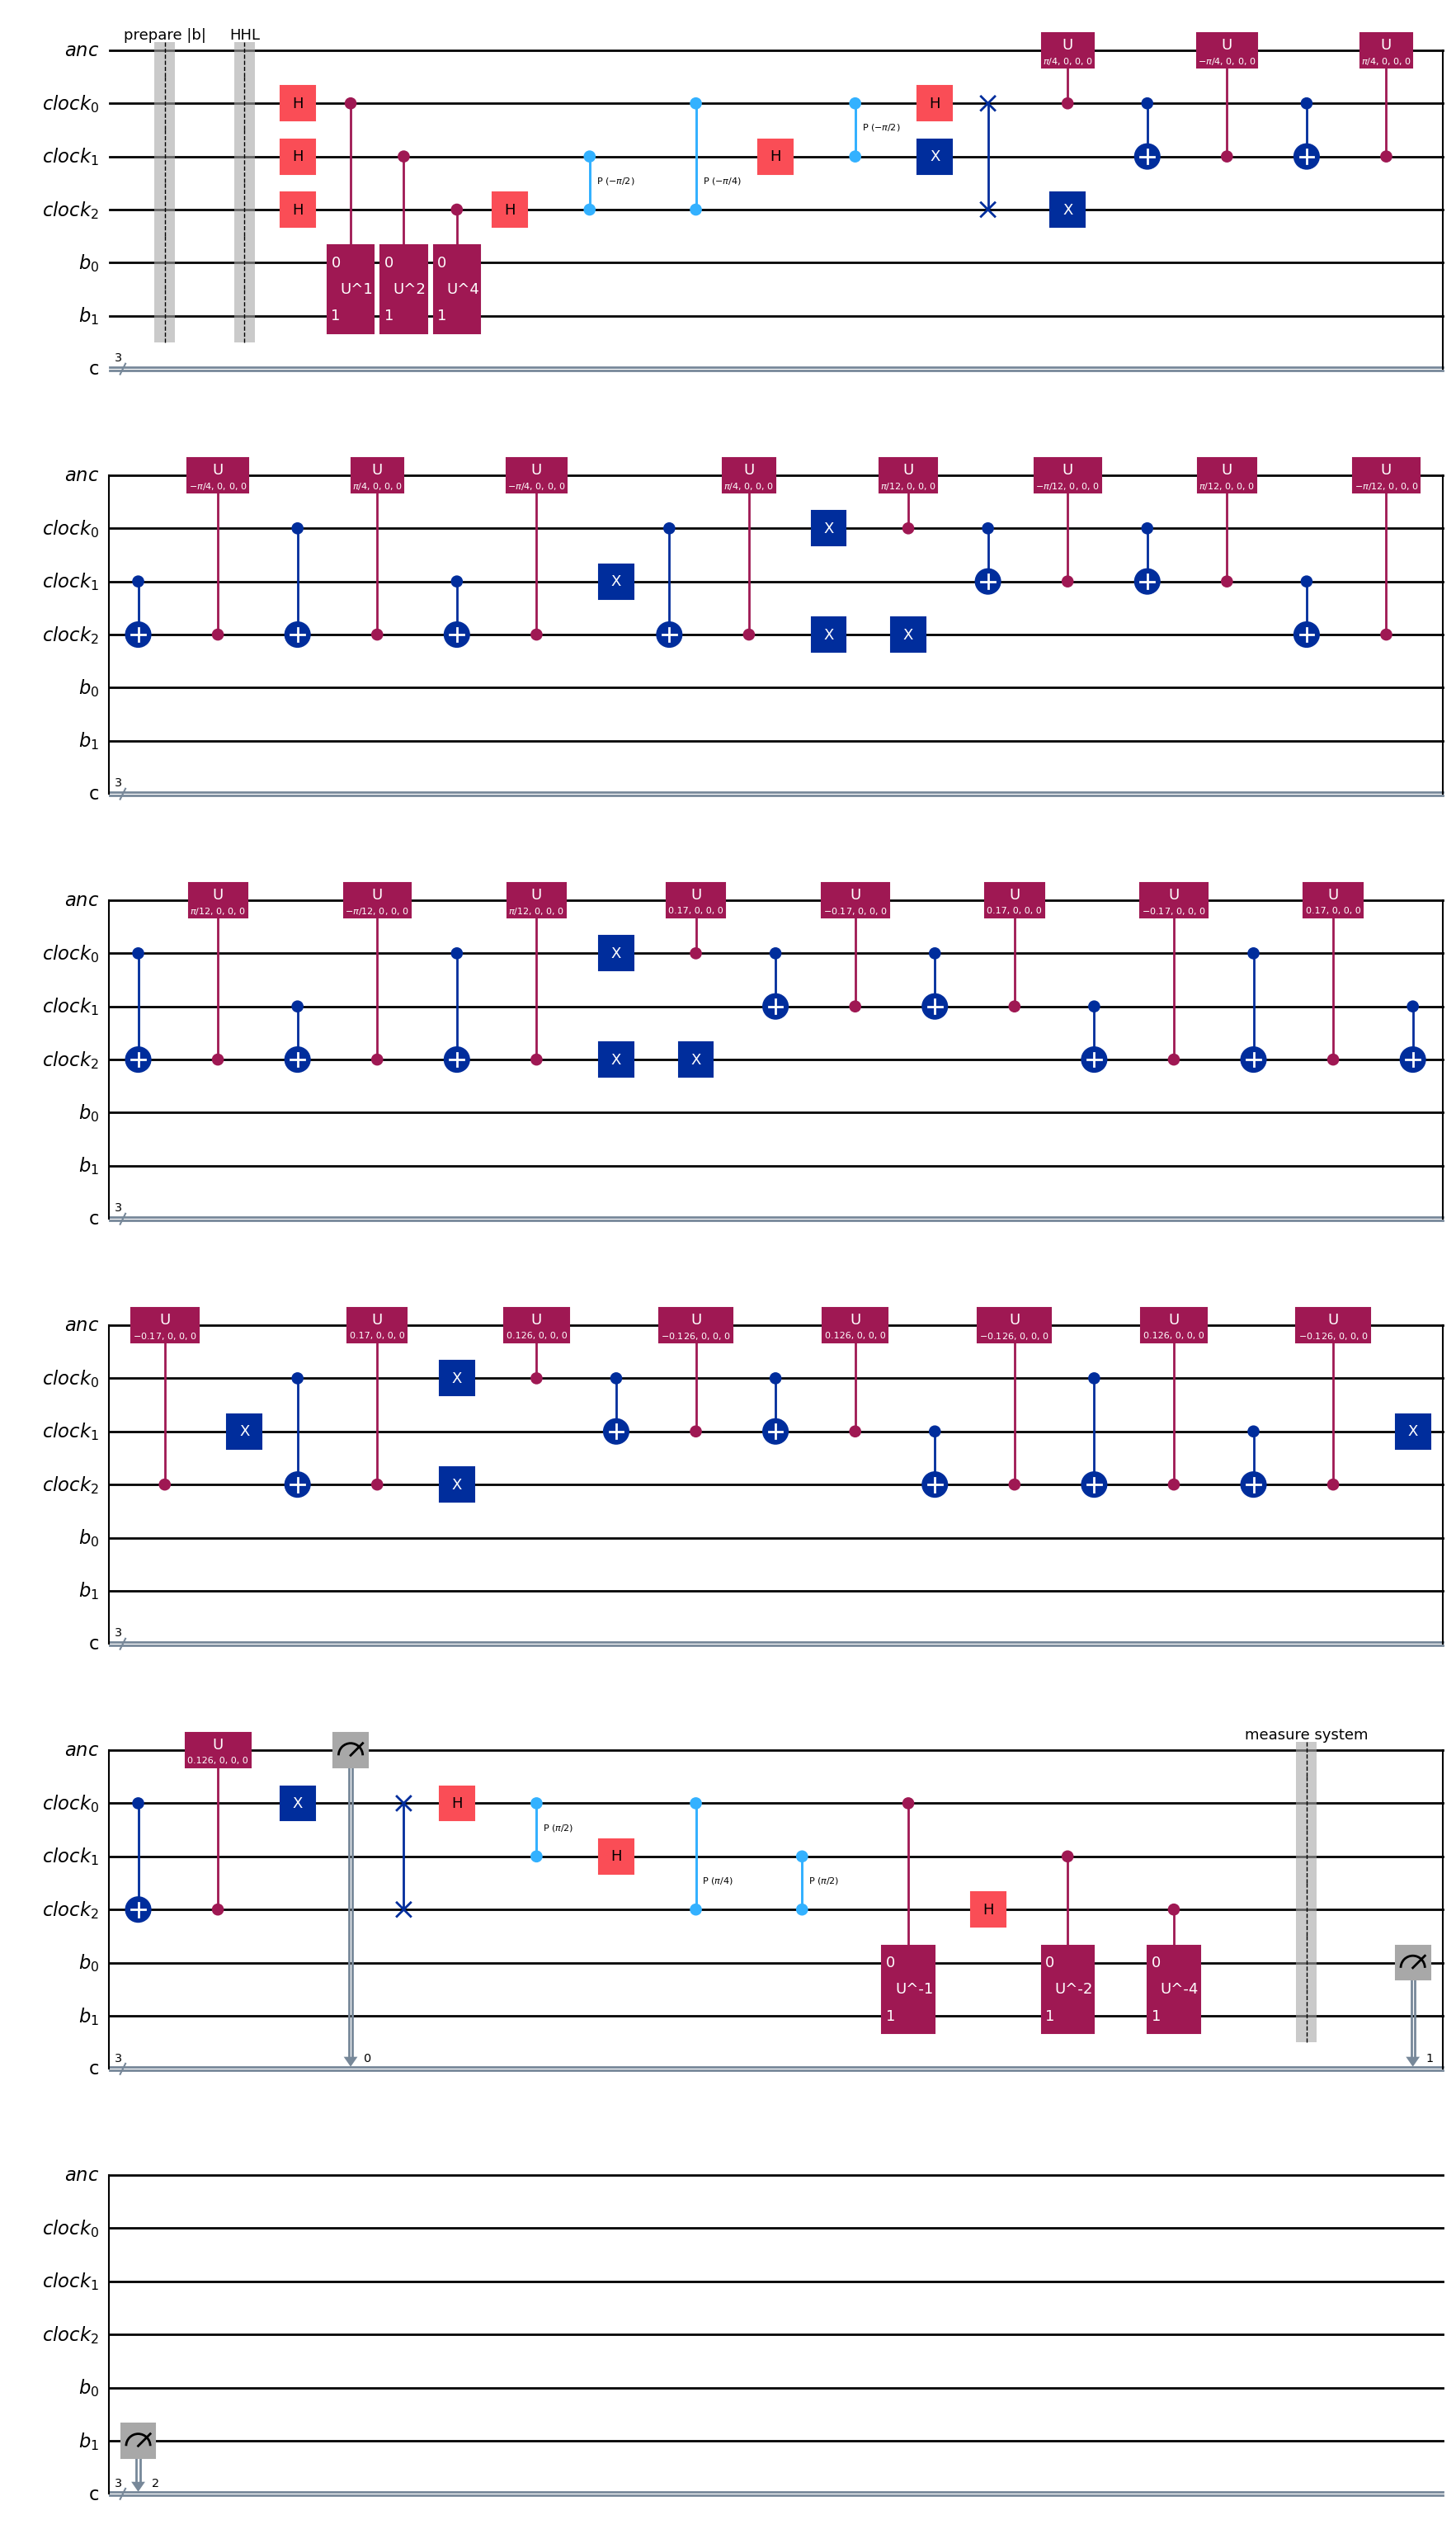

In [ ]:
# QPE, R_y, and HHL circuit

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

# Eigen-decomposition of A (for U = e^{iAt})
eigvals, eigvecs = np.linalg.eigh(A)

# Registers
ancilla = QuantumRegister(1, "anc")
clock = QuantumRegister(3, "clock")      # phase register
b_reg = QuantumRegister(2, "b")          # system register
creg = ClassicalRegister(3, "c")         # c[0]=anc, c[1:3]=system bits

circuit = QuantumCircuit(ancilla, clock, b_reg, creg)

# Inverse QFT on 3-qubit clock register
def qft_dagger(circ, q):
    circ.h(q[2])
    circ.cp(-np.pi / 2, q[1], q[2])
    circ.cp(-np.pi / 4, q[0], q[2])
    circ.h(q[1])
    circ.cp(-np.pi / 2, q[0], q[1])
    circ.h(q[0])
    circ.swap(q[0], q[2])

# QFT on 3-qubit clock register
def qft(circ, q):
    circ.swap(q[0], q[2])
    circ.h(q[0])
    circ.cp(np.pi / 2, q[0], q[1])
    circ.h(q[1])
    circ.cp(np.pi / 4, q[0], q[2])
    circ.cp(np.pi / 2, q[1], q[2])
    circ.h(q[2])

# Controlled U^power based on A
t = 5 * np.pi / 4  # evolution time for U = exp(i A t)

def controlled_U_power(circ, clock_qubit, system_reg, power, sign=+1):
    phases = np.exp(1j * sign * eigvals * t * power)
    U = eigvecs @ np.diag(phases) @ eigvecs.conj().T
    U_gate = UnitaryGate(U, label=f"U^{power}" if sign > 0 else f"U^-{power}")
    circ.append(U_gate.control(1), [clock_qubit, system_reg[0], system_reg[1]])

def apply_controlled_U_powers(circ, clock_reg, system_reg, sign=+1):
    controlled_U_power(circ, clock_reg[0], system_reg, power=1, sign=sign)
    controlled_U_power(circ, clock_reg[1], system_reg, power=2, sign=sign)
    controlled_U_power(circ, clock_reg[2], system_reg, power=4, sign=sign)

# QPE and inverse QPE
def qpe(circ, clock_reg, system_reg):
    circ.h(clock_reg)
    apply_controlled_U_powers(circ, clock_reg, system_reg, sign=+1)
    qft_dagger(circ, clock_reg)

def inv_qpe(circ, clock_reg, system_reg):
    qft(circ, clock_reg)
    apply_controlled_U_powers(circ, clock_reg, system_reg, sign=-1)

# QPE on a single eigenvector to get clock pattern
def qpe_on_eigenvector(eig_index, shots=2048):
    clk = QuantumRegister(3, "clk")
    btmp = QuantumRegister(2, "btmp")
    creg = ClassicalRegister(3, "c")

    qc = QuantumCircuit(clk, btmp, creg)

    u = eigvecs[:, eig_index]
    qc.initialize(u, btmp)

    qc.h(clk)
    apply_controlled_U_powers(qc, clk, btmp, sign=+1)
    qft_dagger(qc, clk)

    qc.measure(clk[0], creg[0])
    qc.measure(clk[1], creg[1])
    qc.measure(clk[2], creg[2])

    tc = transpile(qc, simulator)
    result = simulator.run(tc, shots=shots).result()
    counts = result.get_counts()

    return max(counts, key=counts.get)  # bitstring c2 c1 c0

# Map measured clock patterns to eigenvalues
pattern_to_lambda = {
    qpe_on_eigenvector(i): lam for i, lam in enumerate(eigvals)
}

# Eigenvalue-controlled R_y on ancilla
def apply_eigenvalue_controlled_ry(circ, clock_reg, anc_reg, pattern_to_lambda, C=None):
    if C is None:
        C = min(pattern_to_lambda.values())

    for pattern, lam in pattern_to_lambda.items():
        ratio = C / lam
        if ratio > 1.0:
            raise ValueError(f"C/λ = {ratio} > 1 for λ={lam}, choose smaller C.")

        theta = 2 * np.arcsin(ratio)

        controls = []
        flipped = []
        bit_to_qubit = {0: 2, 1: 1, 2: 0}  # pattern[0]→clock[2], etc.

        for bit_pos, bit in enumerate(pattern):
            q_index = bit_to_qubit[bit_pos]
            if bit == "0":
                circ.x(clock_reg[q_index])
                flipped.append(q_index)
            controls.append(clock_reg[q_index])

        circ.mcry(theta, controls, anc_reg[0], None)

        for q_index in flipped:
            circ.x(clock_reg[q_index])

# HHL routine
def hhl(circ, anc_reg, clock_reg, system_reg, classical_reg):
    qpe(circ, clock_reg, system_reg)
    apply_eigenvalue_controlled_ry(
        circ,
        clock_reg,
        anc_reg,
        pattern_to_lambda,
        C=min(eigvals),
    )
    circ.measure(anc_reg[0], classical_reg[0])
    inv_qpe(circ, clock_reg, system_reg)

# State preparation and full HHL circuit
circuit.barrier(label="prepare |b|")


circuit.barrier(label="HHL")
hhl(circuit, ancilla, clock, b_reg, creg)

circuit.barrier(label="measure system")
circuit.measure(b_reg[0], creg[1])
circuit.measure(b_reg[1], creg[2])

# Draw circuit
circuit.draw(output="mpl")


In [26]:
#Simulate HHL, post-select ancilla = 1, estimate |x⟩

# Transpile and run
tcirc = transpile(circuit, simulator)
result = simulator.run(tcirc, shots=20000).result()
counts = result.get_counts()

# Post-select on ancilla = 1 (c0 is the rightmost classical bit)
post_counts = {}
total_post = 0

for bitstring, count in counts.items():
    if bitstring[-1] == "1":   # ancilla measured into c[0]
        post_counts[bitstring] = count
        total_post += count

print("Post-selected counts (ancilla = 1):")
print(post_counts)
print("Total post-selected shots:", total_post)

# Extract approximate |x⟩ from system bits
amps = np.zeros(4)

for bitstring, count in post_counts.items():
    # Classical bits are c2 c1 c0, with c2,c1 = system (b[1], b[0])
    sys_bits = bitstring[-3:-1]  # c2 c1
    idx = int(sys_bits, 2)
    amps[idx] += count

if total_post > 0:
    probs = amps / total_post
    est_ket_x = np.sqrt(probs)
else:
    est_ket_x = amps

print("\nEstimated |x⟩ from HHL (normalized):")
for i, amp in enumerate(est_ket_x):
    print(f"  |{i:02b}> ≈ {amp:.6f}")

print("\nClassical |x⟩ (normalized):")
for i, amp in enumerate(ket_x):
    print(f"  |{i:02b}> = {amp:.6f}")

overlap = np.vdot(ket_x, est_ket_x)
print(f"\n|⟨x_classical | x_HHL⟩| ≈ {abs(overlap):.6f}")


Post-selected counts (ancilla = 1):
{'101': 1047, '001': 5388, '111': 227, '011': 399}
Total post-selected shots: 7061

Estimated |x⟩ from HHL (normalized):
  |00> ≈ 0.873536
  |01> ≈ 0.237713
  |10> ≈ 0.385070
  |11> ≈ 0.179300

Classical |x⟩ (normalized):
  |00> = 0.873038
  |01> = 0.244451
  |10> = 0.384137
  |11> = 0.174608

|⟨x_classical | x_HHL⟩| ≈ 0.999966


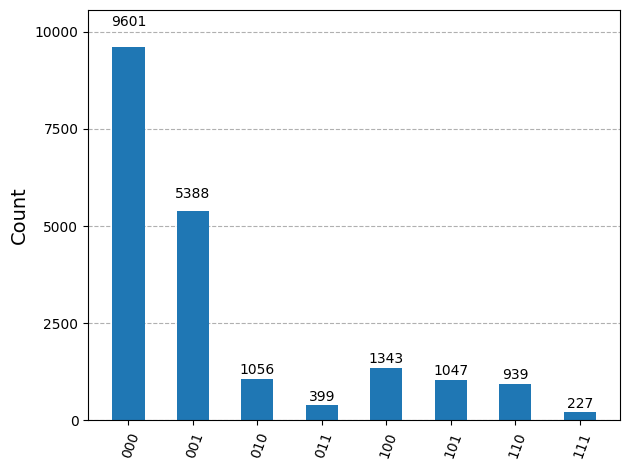

In [27]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)


Variational algorithm

In [ ]:
#H and Pauli decomposition

from qiskit.quantum_info import SparsePauliOp, Operator

# Projector |b⟩⟨b|
ket_b = b / np.linalg.norm(b)
proj_b = np.outer(ket_b, ket_b.conj())

I4 = np.eye(4)

# H = A (I - |b⟩⟨b|) A
H_mat = A @ (I4 - proj_b) @ A

# |x⟩ approximation to a zero-eigenvector
residual = np.linalg.norm(H_mat @ ket_x)
print("‖H |x⟩‖ ≈", residual)

# Pauli decomposition of H
H_pauli = SparsePauliOp.from_operator(Operator(H_mat))
print("\nPauli decomposition of H:")
print(H_pauli)


‖H |x⟩‖ ≈ 1.8703665918870363e-17

Pauli decomposition of H:
SparsePauliOp(['II', 'IX', 'IZ', 'XI', 'XX', 'XZ', 'YY', 'ZI', 'ZX', 'ZZ'],
              coeffs=[ 0.225+0.j, -0.075+0.j, -0.07 +0.j, -0.15 +0.j,  0.03 +0.j,  0.05 +0.j,
 -0.01 +0.j, -0.055+0.j,  0.025+0.j, -0.05 +0.j])


In [ ]:
# VQE 

from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import Statevector

# Dense matrix for H
H_dense = H_pauli.to_matrix()

# 2-qubit variational ansatz
ansatz = EfficientSU2(num_qubits=2, reps=2, entanglement="full")
num_params = ansatz.num_parameters

def energy(theta):
    circ = ansatz.assign_parameters(theta)
    psi = Statevector.from_instruction(circ).data
    return np.real(np.vdot(psi, H_dense @ psi))

# Random search + simple coordinate refinement
rng = np.random.default_rng(123)

best_E = np.inf
best_theta = None

num_random_starts = 200
for _ in range(num_random_starts):
    theta0 = rng.uniform(-2 * np.pi, 2 * np.pi, size=num_params)
    E0 = energy(theta0)
    if E0 < best_E:
        best_E = E0
        best_theta = theta0

print("Best energy after random search:", best_E)

theta = best_theta.copy()
step = 0.1
for _ in range(50):
    improved = False
    for i in range(num_params):
        for delta in (+step, -step):
            trial = theta.copy()
            trial[i] += delta
            Et = energy(trial)
            if Et < best_E:
                best_E = Et
                theta = trial
                improved = True
    if not improved:
        step *= 0.5
        if step < 1e-3:
            break

print("Refined ground-state energy:", best_E)

# Final VQE state
opt_circ = ansatz.assign_parameters(theta)
psi_vqe = Statevector.from_instruction(opt_circ).data

print("\nVQE ground-state amplitudes (|00>, |01>, |10>, |11>):")
for i, amp in enumerate(psi_vqe):
    print(f"  |{i:02b}>: {amp:.6f}")

# Compare with classical |x⟩
overlap = np.vdot(ket_x, psi_vqe)
fidelity = np.abs(overlap) ** 2
print("\n|⟨x_classical | x_VQE⟩|^2 (fidelity) =", fidelity)

# Align global phase for direct amplitude comparison
phase = overlap / np.abs(overlap)
psi_vqe_aligned = psi_vqe * np.conj(phase)

print("\nClassical |x⟩ amplitudes:")
for i, amp in enumerate(ket_x):
    print(f"  |{i:02b}>: {amp:.6f}")

print("\nVQE |x⟩ amplitudes (phase-aligned):")
for i, amp in enumerate(psi_vqe_aligned):
    print(f"  |{i:02b}>: {amp:.6f}")


/var/folders/g_/843wmz8j0_s7pxs6l6c_j9xr0000gn/T/ipykernel_1123/4153079534.py:10: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(num_qubits=2, reps=2, entanglement="full")


Best energy after random search: 0.021606704617197315
Refined ground-state energy: 6.458263660271039e-08

VQE ground-state amplitudes (|00>, |01>, |10>, |11>):
  |00>: -0.769074+0.412623j
  |01>: -0.215643+0.115515j
  |10>: -0.338696+0.181776j
  |11>: -0.154414+0.082590j

|⟨x_classical | x_VQE⟩|^2 (fidelity) = 0.9999994992165343

Classical |x⟩ amplitudes:
  |00>: 0.873038
  |01>: 0.244451
  |10>: 0.384137
  |11>: 0.174608

VQE |x⟩ amplitudes (phase-aligned):
  |00>: 0.872773-0.000051j
  |01>: 0.244633+0.000146j
  |10>: 0.384392-0.000074j
  |11>: 0.175113+0.000215j


In [32]:
# QAOA for ground state of H

# Mixer Hamiltonian B
X = np.array([[0, 1],
              [1, 0]], dtype=complex)
I2 = np.eye(2, dtype=complex)

B_mat = np.kron(X, I2) + np.kron(I2, X)

# exp(-i t M) for Hermitian M
def expm_hermitian(M, t):
    vals, vecs = np.linalg.eigh(M)
    phases = np.exp(-1j * t * vals)
    return vecs @ np.diag(phases) @ vecs.conj().T

# QAOA state and energy
def qaoa_state(params, p=1):
    gammas = params[:p]
    betas = params[p:]

    # |++> = H.H |00> = (1/2)[1,1,1,1]^T
    psi = np.ones(4, dtype=complex) / 2.0

    for layer in range(p):
        Uc = expm_hermitian(H_mat, gammas[layer])
        Ub = expm_hermitian(B_mat, betas[layer])
        psi = Ub @ (Uc @ psi)

    psi = psi / np.linalg.norm(psi)
    return psi

def qaoa_energy(params, p=1):
    psi = qaoa_state(params, p)
    return float(np.real(np.vdot(psi, H_mat @ psi)))

# Random search + local refinement
def qaoa_optimize(p=1, n_trials=100, step=0.1, n_iters=150):
    best_E = np.inf
    best_params = None

    for _ in range(n_trials):
        params = np.random.uniform(0, 2 * np.pi, size=2 * p)
        E = qaoa_energy(params, p)
        if E < best_E:
            best_E = E
            best_params = params.copy()

    params = best_params.copy()
    for _ in range(n_iters):
        improved = False
        for i in range(2 * p):
            for delta in (+step, -step):
                new = params.copy()
                new[i] = (new[i] + delta) % (2 * np.pi)
                E = qaoa_energy(new, p)
                if E < best_E:
                    best_E = E
                    params = new
                    improved = True
        if not improved:
            break

    return best_E, params

# Run QAOA
p = 1
best_E_qaoa, best_params_qaoa = qaoa_optimize(p=p)
print(f"Best QAOA energy (p={p}):", best_E_qaoa)
print("Best params (gammas | betas):", best_params_qaoa)

psi_qaoa = qaoa_state(best_params_qaoa, p=p)

print("\nQAOA state amplitudes (|00>, |01>, |10>, |11>):")
for i, amp in enumerate(psi_qaoa):
    print(f"  |{i:02b}>: {amp:.6f}")

# Compare with classical |x⟩
overlap_qaoa = np.vdot(ket_x, psi_qaoa)
fidelity_qaoa = np.abs(overlap_qaoa) ** 2
print("\n|⟨x_classical | x_QAOA⟩|^2 (fidelity) =", fidelity_qaoa)

# Phase-aligned amplitudes
phase_qaoa = overlap_qaoa / np.abs(overlap_qaoa)
psi_qaoa_aligned = psi_qaoa * np.conj(phase_qaoa)

print("\nClassical |x⟩ amplitudes:")
for i, amp in enumerate(ket_x):
    print(f"  |{i:02b}>: {amp:.6f}")


print("\nQAOA |x⟩ amplitudes (phase-aligned, real parts):")
for i, amp in enumerate(psi_qaoa_aligned):
    print(f"  |{i:02b}>: {amp.real:.6f}")



Best QAOA energy (p=1): 0.022194273004392848
Best params (gammas | betas): [3.282998 5.976232]

QAOA state amplitudes (|00>, |01>, |10>, |11>):
  |00>: 0.488247+0.351161j
  |01>: 0.387864+0.237886j
  |10>: 0.360052+0.210618j
  |11>: 0.475679+0.176083j

|⟨x_classical | x_QAOA⟩|^2 (fidelity) = 0.7781513260249266

Classical |x⟩ amplitudes:
  |00>: 0.873038
  |01>: 0.244451
  |10>: 0.384137
  |11>: 0.174608

QAOA |x⟩ amplitudes (phase-aligned, real parts):
  |00>: 0.600568
  |01>: 0.454910
  |10>: 0.416776
  |11>: 0.495443


## Interpretation of Results

The HHL implementation demonstrates the theoretical capability of quantum algorithms to encode linear system solutions in quantum states, highlighting their asymptotic power under idealized conditions. However, circuit depth and noise sensitivity limit near-term applicability.

In contrast, the variational method yields approximate solutions through iterative optimization, trading asymptotic speedup for hardware feasibility. The agreement between quantum and classical solutions validates the correctness of the hybrid pipeline.

This contrast reflects the current state of quantum computing: fault-tolerant algorithms define the long-term frontier, while variational methods dominate near-term experimentation.


## Limitations

The examples considered are intentionally small to permit transparent demonstration. HHL remains impractical for large systems on current hardware, while variational solvers face optimization landscape and scaling challenges.

These results should therefore be viewed as methodological demonstrations rather than production-ready solvers.


## Future Directions

Future work will integrate quantum linear solvers into quantum machine learning pipelines, differential equation solvers, and molecular simulation workflows. Hybrid quantum–classical linear algebra routines are expected to become core primitives in scalable quantum scientific computing.
